# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
# settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/kcah/Documents/code-repo/air-quality-prediction


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 19, 17, 10, 19, 910010)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_HELSINKI_JSON").value
locations = json.loads(location_str)
# Pick the first location object as the target, or modify as needed
location = locations[0]
country = location['country']
city = location['city']
street = location['street']

# Get unique streets from locations
if isinstance(locations, list):
    unique_streets = [loc['street'] for loc in locations]
else:
    unique_streets = [locations['street']]

print(f"Found {len(unique_streets)} street(s) to process:")
for i, street in enumerate(unique_streets, 1):
    print(f"  {i}. {street}")

2025-11-19 17:10:19,920 INFO: Initializing external client
2025-11-19 17:10:19,920 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-19 17:10:20,576 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-19 17:10:21,559 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279136
Found 4 street(s) to process:
  1. kluuvi
  2. kallio-2
  3. mannerheimintie
  4. vartiokyla-huivipolku


## <span style="color:#ff5f27;">🪝 Download models from Model Registry and Process Each Street</span>

In [5]:
mr = project.get_model_registry()

# retrieved_model = mr.get_model(
#     name="air_quality_helsinki_xgboost_model",
#     version=1,
# )

# fv = retrieved_model.get_feature_view()

# # Download the saved model artifacts to a local directory
# saved_model_dir = retrieved_model.download()

In [6]:
# # Loading the XGBoost regressor model and label encoder from the saved model directory
# # retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
# retrieved_xgboost_model = XGBRegressor()

# retrieved_xgboost_model.load_model(saved_model_dir + "/model_helsinki.json")

# # Displaying the retrieved XGBoost regressor model
# retrieved_xgboost_model

## <span style="color:#ff5f27;">✨ Process Each Street Separately   </span>


In [7]:
# Get weather forecast data (shared across all streets in the same city)
weather_fg = fs.get_feature_group(
    name='weather_helsinki',
    version=1,
)
batch_data_all = weather_fg.filter(weather_fg.date >= today).read()
# Add empty lag columns for the model
batch_data_all['pm25_lag_1d'] = float('nan')
batch_data_all['pm25_lag_2d'] = float('nan')
batch_data_all['pm25_lag_3d'] = float('nan')
batch_data_all

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.58s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,rain_sum,city,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d
0,2025-11-22 00:00:00+00:00,1.95,0.0,10.703569,222.273621,0.00,helsinki,NaN,NaN,NaN
1,2025-11-20 00:00:00+00:00,2.85,0.4,13.779114,199.855301,0.40,helsinki,NaN,NaN,NaN
2,2025-11-24 00:00:00+00:00,4.35,0.1,13.584932,212.005341,0.10,helsinki,NaN,NaN,NaN
3,2025-11-27 00:00:00+00:00,-2.40,0.0,5.959060,334.983124,0.00,helsinki,NaN,NaN,NaN
4,2025-11-25 00:00:00+00:00,1.95,0.0,8.121970,282.804260,0.00,helsinki,NaN,NaN,NaN
5,2025-11-26 00:00:00+00:00,3.20,0.0,9.720000,270.000000,0.00,helsinki,NaN,NaN,NaN
6,2025-11-21 00:00:00+00:00,0.65,0.1,7.928178,357.397491,0.05,helsinki,NaN,NaN,NaN
7,2025-11-23 00:00:00+00:00,4.65,0.1,10.739832,230.440369,0.10,helsinki,NaN,NaN,NaN
8,2025-11-28 00:00:00+00:00,-2.55,0.0,2.036468,44.999897,0.00,helsinki,NaN,NaN,NaN
9,2025-11-29 00:00:00+00:00,-0.55,0.0,11.609651,119.744789,0.00,helsinki,NaN,NaN,NaN


### <span style="color:#ff5f27;">🤖 Process each street separately</span>


Processing street: kluuvi (model: air_quality_helsinki_xgboost_model_kluuvi)


Downloading: 0.000%|          | 0/552157 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/82990 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28023 elapsed<00:00 remaining<?

--- Batch data for kluuvi --- dirs, 3 files)... DONE
                       date  temperature_2m_mean  precipitation_sum  \
1 2025-11-20 00:00:00+00:00                 2.85                0.4   
6 2025-11-21 00:00:00+00:00                 0.65                0.1   
0 2025-11-22 00:00:00+00:00                 1.95                0.0   
7 2025-11-23 00:00:00+00:00                 4.65                0.1   
2 2025-11-24 00:00:00+00:00                 4.35                0.1   
4 2025-11-25 00:00:00+00:00                 1.95                0.0   
5 2025-11-26 00:00:00+00:00                 3.20                0.0   
3 2025-11-27 00:00:00+00:00                -2.40                0.0   
8 2025-11-28 00:00:00+00:00                -2.55                0.0   
9 2025-11-29 00:00:00+00:00                -0.55                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant  rain_sum      city  \
1           13.779114                   199.855301      0.40  helsinki   
6            7.92

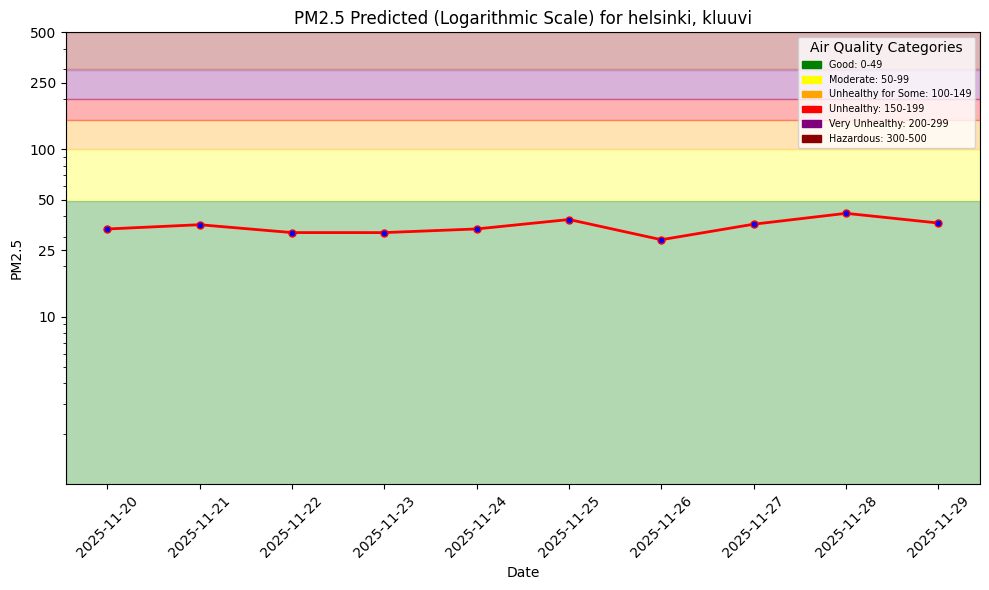

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_helsinki_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279136/jobs/named/aq_predictions_helsinki_1_offline_fg_materialization/executions
2025-11-19 17:10:48,804 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-19 17:10:55,342 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-19 17:13:06,902 INFO: Waiting for execution to finish. Current state: FINISHED. Final status: SUCCEEDED
2025-11-19 17:13:07,336 INFO: Waiting for log aggregation to finish.
2025-11-19 17:13:07,337 INFO: Execution finished successfully.
Inserted predictions for kluuvi into feature group
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.67s) 
Hindcast data for kluuvi: 6 records
monitoring_df for kluuvi:
                       date  temperature_2m_mean  precipitation_sum  \
0 2025-11-22 00:00:0

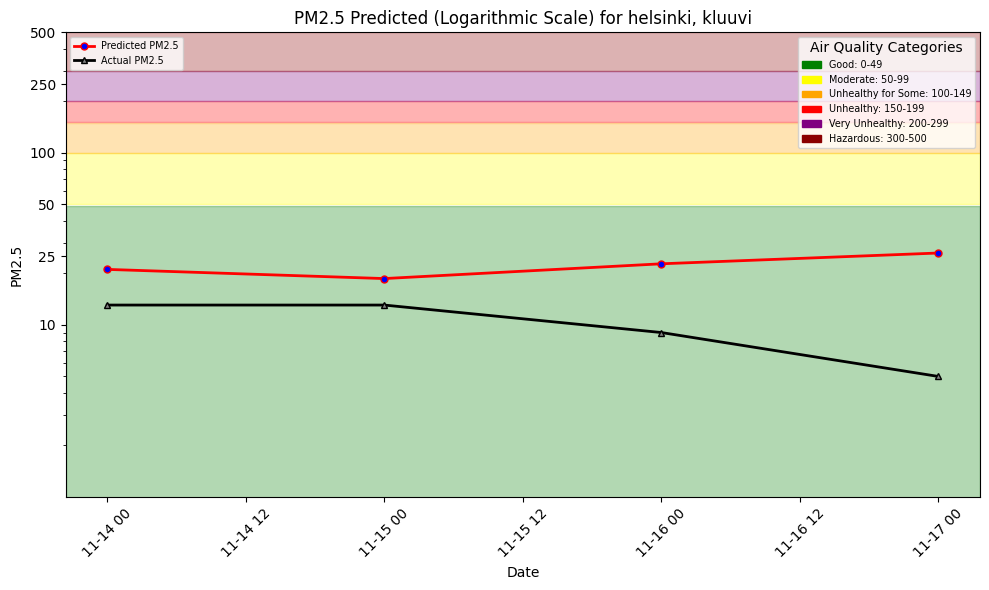

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/docs/air-quality/assets/img/pm25_forecast_klu…

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/docs/air-quality/assets/img/pm25_hindcast_1da…

Uploaded images for kluuvi

Processing street: kallio-2 (model: air_quality_helsinki_xgboost_model_kallio_2)


Downloading: 0.000%|          | 0/532124 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/85263 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27685 elapsed<00:00 remaining<?

--- Batch data for kallio-2 ---irs, 3 files)... DONE
                       date  temperature_2m_mean  precipitation_sum  \
1 2025-11-20 00:00:00+00:00                 2.85                0.4   
6 2025-11-21 00:00:00+00:00                 0.65                0.1   
0 2025-11-22 00:00:00+00:00                 1.95                0.0   
7 2025-11-23 00:00:00+00:00                 4.65                0.1   
2 2025-11-24 00:00:00+00:00                 4.35                0.1   
4 2025-11-25 00:00:00+00:00                 1.95                0.0   
5 2025-11-26 00:00:00+00:00                 3.20                0.0   
3 2025-11-27 00:00:00+00:00                -2.40                0.0   
8 2025-11-28 00:00:00+00:00                -2.55                0.0   
9 2025-11-29 00:00:00+00:00                -0.55                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant  rain_sum      city  \
1           13.779114                   199.855301      0.40  helsinki   
6            7.92

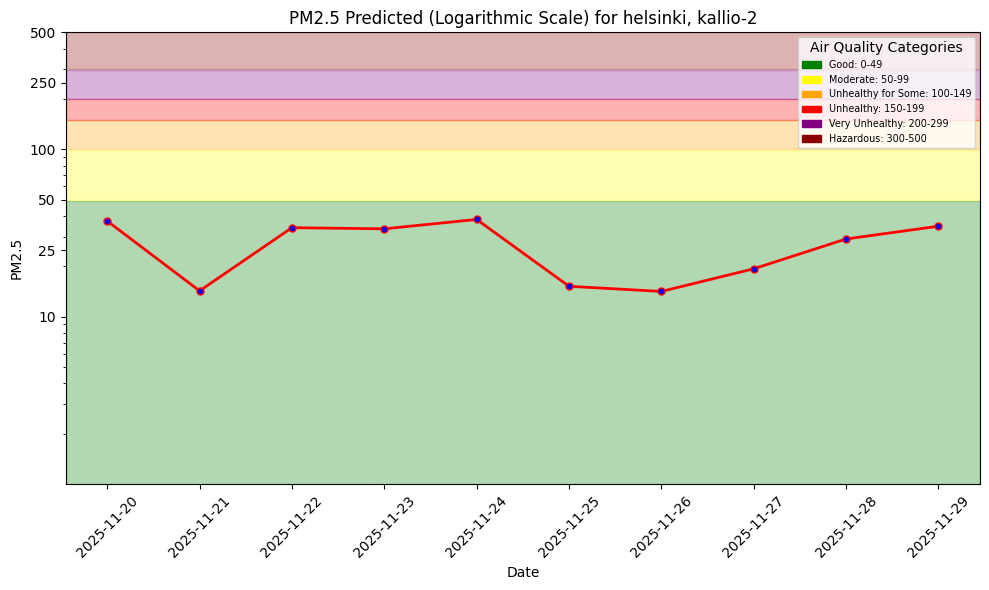

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_helsinki_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279136/jobs/named/aq_predictions_helsinki_1_offline_fg_materialization/executions
2025-11-19 17:13:39,310 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-19 17:13:42,589 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-19 17:15:31,437 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-19 17:15:31,598 INFO: Waiting for log aggregation to finish.
2025-11-19 17:15:43,845 INFO: Execution finished successfully.
Inserted predictions for kallio-2 into feature group
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.84s) 
Hindcast data for kallio-2: 2 records
monitoring_df for kallio-2:
                       date  temperature_2m_mean  precipitation_sum  \
0 2025

Uploading Dataframe: 0.00% |          | Rows 0/0 | Elapsed Time: 00:00 | Remaining Time: ?


Launching job: aq_predictions_helsinki_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279136/jobs/named/aq_predictions_helsinki_1_offline_fg_materialization/executions
2025-11-19 17:16:05,353 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-19 17:16:08,649 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-19 17:17:01,321 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-19 17:17:01,492 INFO: Waiting for log aggregation to finish.
2025-11-19 17:17:10,237 INFO: Execution finished successfully.
Hindcast data for kallio-2: 0 records
hindcast_df for kallio-2:
Empty DataFrame
Columns: [date, predicted_pm25, pm25]
Index: []


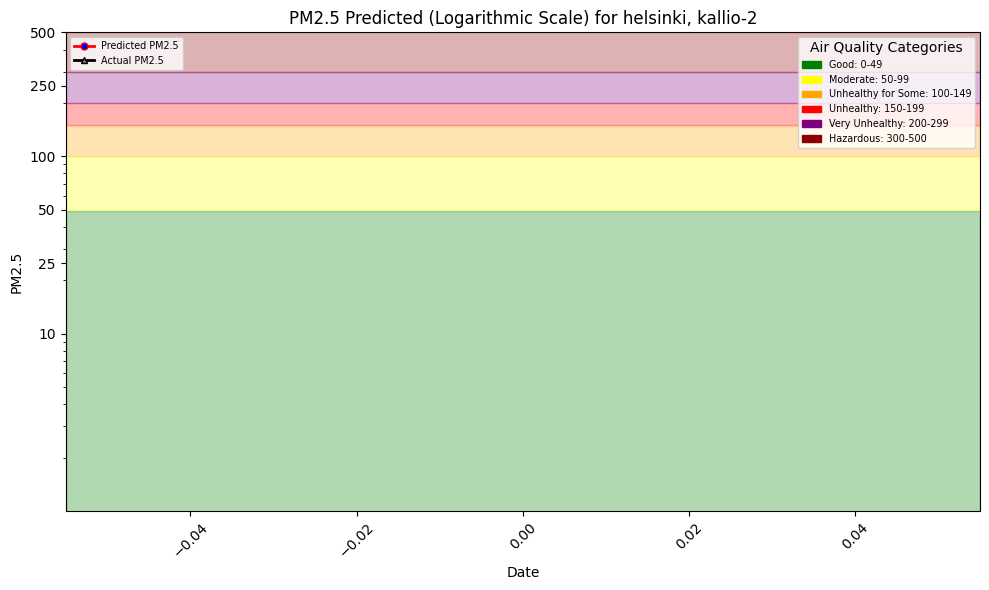

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/docs/air-quality/assets/img/pm25_forecast_kal…

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/docs/air-quality/assets/img/pm25_hindcast_1da…

Uploaded images for kallio-2

Processing street: mannerheimintie (model: air_quality_helsinki_xgboost_model_mannerheimintie)


Downloading: 0.000%|          | 0/534803 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/83495 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27752 elapsed<00:00 remaining<?

--- Batch data for mannerheimintie ---files)... DONE
                       date  temperature_2m_mean  precipitation_sum  \
1 2025-11-20 00:00:00+00:00                 2.85                0.4   
6 2025-11-21 00:00:00+00:00                 0.65                0.1   
0 2025-11-22 00:00:00+00:00                 1.95                0.0   
7 2025-11-23 00:00:00+00:00                 4.65                0.1   
2 2025-11-24 00:00:00+00:00                 4.35                0.1   
4 2025-11-25 00:00:00+00:00                 1.95                0.0   
5 2025-11-26 00:00:00+00:00                 3.20                0.0   
3 2025-11-27 00:00:00+00:00                -2.40                0.0   
8 2025-11-28 00:00:00+00:00                -2.55                0.0   
9 2025-11-29 00:00:00+00:00                -0.55                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant  rain_sum      city  \
1           13.779114                   199.855301      0.40  helsinki   
6            7.92

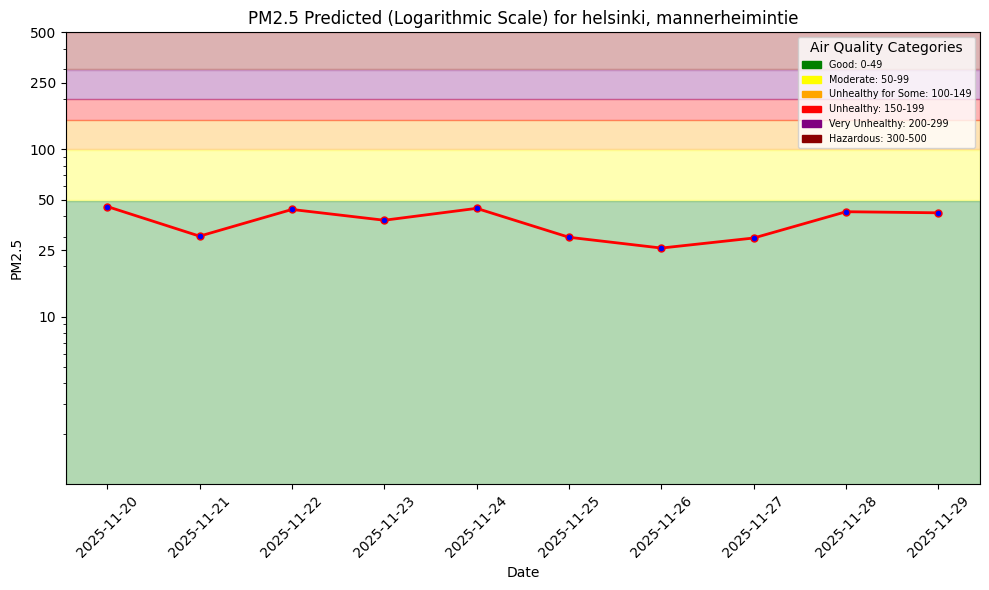

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_helsinki_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279136/jobs/named/aq_predictions_helsinki_1_offline_fg_materialization/executions
2025-11-19 17:17:36,760 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-19 17:17:40,067 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-19 17:19:20,042 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-19 17:19:20,229 INFO: Waiting for log aggregation to finish.
2025-11-19 17:19:29,028 INFO: Execution finished successfully.
Inserted predictions for mannerheimintie into feature group
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.23s) 
Hindcast data for mannerheimintie: 2 records
monitoring_df for mannerheimintie:
                       date  temperature_2m_mean  precip

Uploading Dataframe: 0.00% |          | Rows 0/0 | Elapsed Time: 00:00 | Remaining Time: ?


Launching job: aq_predictions_helsinki_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279136/jobs/named/aq_predictions_helsinki_1_offline_fg_materialization/executions
2025-11-19 17:19:53,755 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-19 17:19:57,043 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-19 17:22:34,275 WARNING: Retrying (Retry(total=0, connect=None, read=False, redirect=None, status=None)) after connection broken by 'MustRedialError('Remote peer just closed our connection, probably for not answering to unsolicited packet. (None)')': /hopsworks-api/api/project/1279136/jobs/aq_predictions_helsinki_1_offline_fg_materialization/executions/3894028
2025-11-19 17:22:35,044 INFO: Waiting for execution to finish. Current state: FINISHED. Final status: SUCCEEDED
2025-11-19 17:22:35,507 INFO: Waiting for log aggre

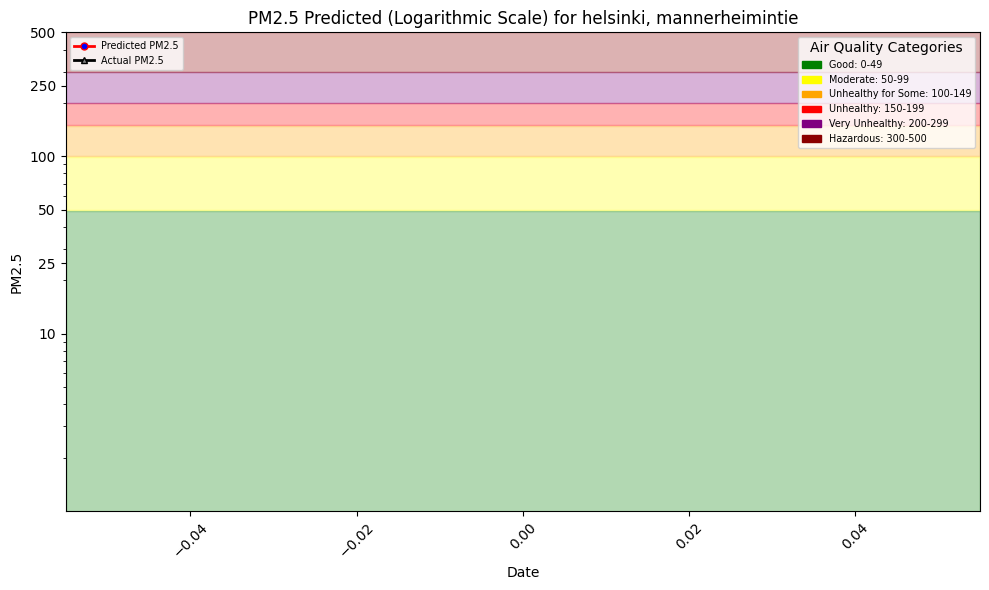

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/docs/air-quality/assets/img/pm25_forecast_man…

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/docs/air-quality/assets/img/pm25_hindcast_1da…

Uploaded images for mannerheimintie

Processing street: vartiokyla-huivipolku (model: air_quality_helsinki_xgboost_model_vartiokyla_huivipolku)


Downloading: 0.000%|          | 0/519582 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/87620 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27957 elapsed<00:00 remaining<?

--- Batch data for vartiokyla-huivipolku ---... DONE
                       date  temperature_2m_mean  precipitation_sum  \
1 2025-11-20 00:00:00+00:00                 2.85                0.4   
6 2025-11-21 00:00:00+00:00                 0.65                0.1   
0 2025-11-22 00:00:00+00:00                 1.95                0.0   
7 2025-11-23 00:00:00+00:00                 4.65                0.1   
2 2025-11-24 00:00:00+00:00                 4.35                0.1   
4 2025-11-25 00:00:00+00:00                 1.95                0.0   
5 2025-11-26 00:00:00+00:00                 3.20                0.0   
3 2025-11-27 00:00:00+00:00                -2.40                0.0   
8 2025-11-28 00:00:00+00:00                -2.55                0.0   
9 2025-11-29 00:00:00+00:00                -0.55                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant  rain_sum      city  \
1           13.779114                   199.855301      0.40  helsinki   
6            7.92

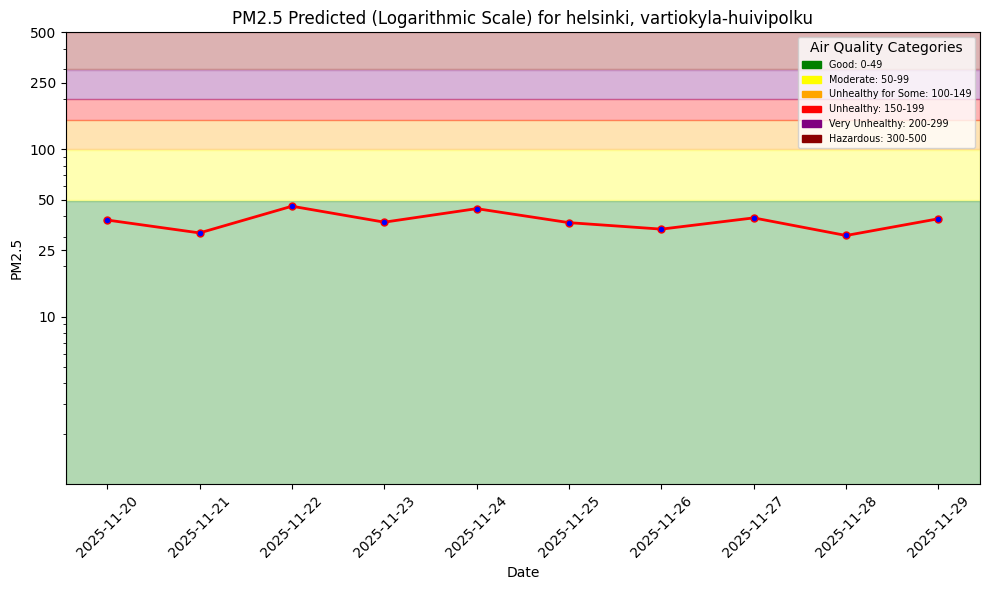

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_helsinki_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279136/jobs/named/aq_predictions_helsinki_1_offline_fg_materialization/executions
2025-11-19 17:23:02,998 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-19 17:23:06,287 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-19 17:25:50,136 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-19 17:25:50,307 INFO: Waiting for log aggregation to finish.
2025-11-19 17:25:59,041 INFO: Execution finished successfully.
Inserted predictions for vartiokyla-huivipolku into feature group
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.68s) 
Hindcast data for vartiokyla-huivipolku: 2 records
monitoring_df for vartiokyla-huivipolku:
                       date  temperatu

Uploading Dataframe: 0.00% |          | Rows 0/0 | Elapsed Time: 00:00 | Remaining Time: ?


Launching job: aq_predictions_helsinki_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279136/jobs/named/aq_predictions_helsinki_1_offline_fg_materialization/executions
2025-11-19 17:26:20,649 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-19 17:26:23,979 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-19 17:27:13,965 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-19 17:27:14,149 INFO: Waiting for log aggregation to finish.
2025-11-19 17:27:26,435 INFO: Execution finished successfully.
Hindcast data for vartiokyla-huivipolku: 0 records
hindcast_df for vartiokyla-huivipolku:
Empty DataFrame
Columns: [date, predicted_pm25, pm25]
Index: []


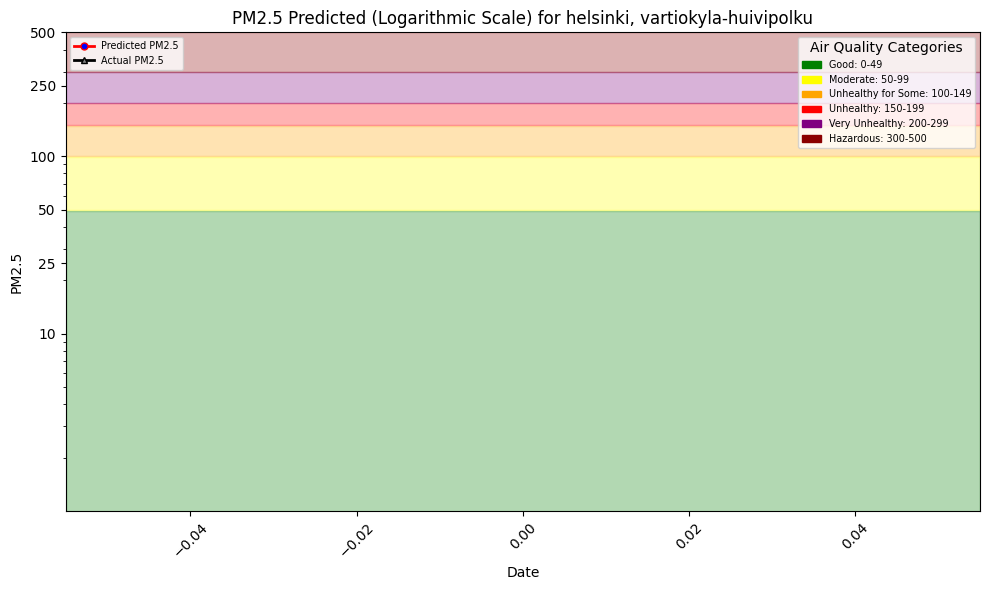

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/docs/air-quality/assets/img/pm25_forecast_var…

Uploading /Users/kcah/Documents/code-repo/air-quality-prediction/docs/air-quality/assets/img/pm25_hindcast_1da…

Uploaded images for vartiokyla-huivipolku

Processing complete for all 4 street(s)
See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279136/settings/fb/path/Resources/airquality


In [8]:
# Get or create feature group (shared across all streets)
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_helsinki',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

# Process each street separately
for street in unique_streets:
    street_safe = street.replace('-', '_')
    model_name = f"air_quality_helsinki_xgboost_model_{street_safe}"
    
    print(f"\n{'='*60}")
    print(f"Processing street: {street} (model: {model_name})")
    print(f"{'='*60}")
    
    # Get location info for this street
    if isinstance(locations, list):
        selected_location = next((loc for loc in locations if loc['street'] == street), None)
    else:
        selected_location = locations if locations['street'] == street else None
    
    if selected_location is None:
        print(f"Warning: Could not find location info for street {street}, skipping...")
        continue
    
    country = selected_location['country']
    city = selected_location['city']
    
    # Download the model for this street
    try:
        retrieved_model = mr.get_model(
            name=model_name,
            version=2,
        )
        saved_model_dir = retrieved_model.download()
    except Exception as e:
        print(f"Error loading model {model_name}: {e}")
        print(f"Skipping street {street}...")
        continue
    
    # Load the XGBoost model
    retrieved_xgboost_model = XGBRegressor()
    model_file = f"{saved_model_dir}/model_{street_safe}.json"
    
    retrieved_xgboost_model.load_model(model_file)
    
    # Make a copy of batch data for this street
    batch_data = batch_data_all.copy()
    
    # Make predictions
    batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
        batch_data[['pm25_lag_1d', 'pm25_lag_2d', 'pm25_lag_3d', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'rain_sum']])
    
    # Add street, city, country columns
    batch_data['street'] = street
    batch_data['city'] = city
    batch_data['country'] = country
    batch_data = batch_data.sort_values(by=['date'])
    batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
    # batch_data = batch_data.sort_values(by=['date'])
    
    print(f"--- Batch data for {street} ---")
    print(batch_data)
    print(f"Generated {len(batch_data)} predictions for {street}")
    print(batch_data[['date', 'predicted_pm25', 'street']].head())
    
    # Display info for this street
    print(f"\nData info for {street}:")
    batch_data.info()
    
    # Create forecast graph for this street
    street_safe_file = street.replace('-', '_')
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{street_safe_file}.png"
    plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)
    plt.show()
    
    # Insert predictions for this street
    monitor_fg.insert(batch_data, wait=True)
    print(f"Inserted predictions for {street} into feature group")
    
    # We will create a hindcast chart for only the forecasts made 1 day beforehand for this street
    monitoring_df = monitor_fg.filter(
        (monitor_fg.days_before_forecast_day == 1) & 
        (monitor_fg.street == street)
    ).read()
    print(f"Hindcast data for {street}: {len(monitoring_df)} records")
    print(f"monitoring_df for {street}:")
    print(monitoring_df)
    
    # Get air quality data for this street
    air_quality_fg = fs.get_feature_group(name='air_quality_helsinki', version=1)
    air_quality_df = air_quality_fg.filter(air_quality_fg.street == street).read()
    print(f"Air quality data for {street}: {len(air_quality_df)} records")
    
    outcome_df = air_quality_df[['date', 'pm25']]
    preds_df = monitoring_df[['date', 'predicted_pm25']]

    hindcast_df = pd.merge(preds_df, outcome_df, on="date")
    hindcast_df = hindcast_df.sort_values(by=['date'])

    # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
    if len(hindcast_df) == 0:
        hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
        # Select only the required columns for hindcast_df
        hindcast_df = hindcast_df[['date', 'predicted_pm25', 'pm25']]

    print(f"Hindcast data for {street}: {len(hindcast_df)} records")
    print(f"hindcast_df for {street}:")
    print(hindcast_df)
    
    # Create hindcast graph for this street
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{street_safe_file}.png"
    plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
    plt.show()
    
    # Upload images for this street
    dataset_api = project.get_dataset_api()
    str_today = today.strftime("%Y-%m-%d")
    if dataset_api.exists("Resources/airquality") == False:
        dataset_api.mkdir("Resources/airquality")
    dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
    dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
    
    print(f"Uploaded images for {street}")

# After processing all streets
proj_url = project.get_url()
print(f"\n{'='*60}")
print(f"Processing complete for all {len(unique_streets)} street(s)")
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")
print(f"{'='*60}")

### <span style="color:#ff5f27;">✅ Processing Complete</span>

All streets have been processed in the loop above. Each street:
- Has its own model loaded from the Model Registry
- Has predictions generated and stored in the monitoring feature group
- Has forecast and hindcast graphs generated
- Has images uploaded to Hopsworks

### 📈 Hindcast Analysis

Hindcast graphs comparing predicted vs actual values are generated for each street in the processing loop above.

__Note: These graphs will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in these graphs.

### ☁️ Image Uploads

Prediction and hindcast dashboard images (PNG files) are uploaded to Hopsworks for each street in the processing loop above.


---